각 채널별로 channel_video_text_data의 '대표영상텍스트' 컬럼의 TF-IDF 기반 키워드를 추출하고, 이를 각 채널별 댓글 키워드와 비교하여 유사도를 계산하고 시각화

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from konlpy.tag import Mecab
from collections import Counter
import re

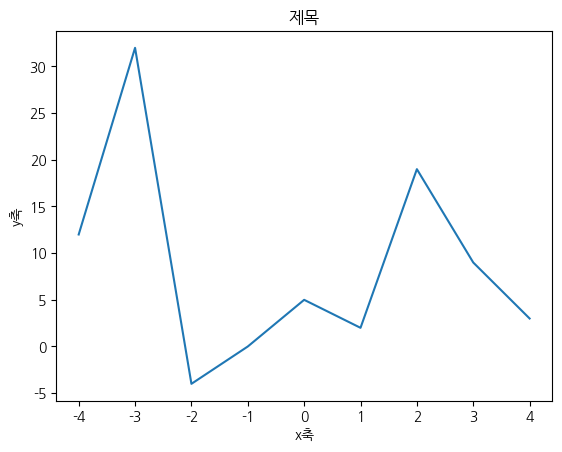

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], [12, 32, -4, 0, 5, 2, 19, 9, 3])
plt.xlabel('x축')
plt.ylabel('y축')
plt.title('제목')
plt.show()

In [3]:

# 데이터 로드
file_path = 'youtube_channel_comments_data_20240606_104600.csv'
data = pd.read_csv(file_path)
video_text_data = pd.read_csv('youtube_channel_video_text_data.csv')



In [4]:
# video_text_data에 '채널ID' 컬럼 추가
video_text_data['channelId'] = video_text_data['채널ID']

In [5]:
video_text_data.head()

,채널구분,채널ID,제목,개설 날짜,구독자,영상ID,대표영상텍스트,channelId
0,A,UCMFk5S7g5DY-CZNVh_Kyz_A,약사가 들려주는 약 이야기,2017-03-02,"1,780,000",rFzEHqZTt8w,우리 집에다가 무심코 놔둔 생활용품들이 건강을 망칠 수가 있습니다. 아무리 유발하...,UCMFk5S7g5DY-CZNVh_Kyz_A
1,A,UCMFk5S7g5DY-CZNVh_Kyz_A,약사가 들려주는 약 이야기,2017-03-02,"1,780,000",q4RDfkw177Y,주방은 우리 가족의 먹거리는 데단이 중요한 것이죠. 그런데 주방에서 사용하는 물건...,UCMFk5S7g5DY-CZNVh_Kyz_A
2,A,UCMFk5S7g5DY-CZNVh_Kyz_A,약사가 들려주는 약 이야기,2017-03-02,"1,780,000",1a6s-lpMxdc,"커피를 건강하게 마시지 못하면 고지열증, 고콜렛스테로 열정이 생기고 당뇨병이 생기...",UCMFk5S7g5DY-CZNVh_Kyz_A
3,B,UC3iSLVH0MxHfwO69oHKpvog,리틀약사,2015-02-16,"454,000",rDIFXZD6TN8,밥할 때 넣으면 좋은 것 3가지. 첫 번째 소주. 현미밥 1인분을 할 때 소주 2...,UC3iSLVH0MxHfwO69oHKpvog
4,B,UC3iSLVH0MxHfwO69oHKpvog,리틀약사,2015-02-16,"454,000",hxJLOR9e7Nw,누룽지와 숙룡 이런 분들 절대 먹지 마세요. 답소 날뢰쪽 온도가 220에서 250...,UC3iSLVH0MxHfwO69oHKpvog


In [6]:
# data에 video_text_data를 참조해서 channelId가 같은 행에 대해 video_text_data의 '채널구분'컬럼을 data에 추가
data = data.merge(video_text_data[['channelId', '채널구분']], on='channelId', how='left')
# 결과 확인
print(data[['channelId', '채널구분']].head())

                  channelId 채널구분
0  UCMFk5S7g5DY-CZNVh_Kyz_A    A
1  UCMFk5S7g5DY-CZNVh_Kyz_A    A
2  UCMFk5S7g5DY-CZNVh_Kyz_A    A
3  UCMFk5S7g5DY-CZNVh_Kyz_A    A
4  UCMFk5S7g5DY-CZNVh_Kyz_A    A


In [7]:

# Convert videoPublishedAt to datetime
data['videoPublishedAt'] = pd.to_datetime(data['videoPublishedAt'])

# Calculate the view counts for each video
video_view_counts = data.groupby(['channelId', 'videoId', 'videoTitle']).agg(
    viewCount=('viewCount', 'first')
).reset_index()

In [8]:
# Get top 3 most viewed videos for each channel
top_videos = video_view_counts.sort_values(by='viewCount', ascending=False).groupby('channelId').head(3)

# Filter the original data to include only comments from the top videos
top_video_comments = data[data['videoId'].isin(top_videos['videoId'])]

top_video_comments.shape

(19233, 20)

In [9]:
# 한국어 불용어 리스트
stop_words  = set([
    '이', '그', '저', '것', '수', '것을', '그리고', '더', '더욱', '너무', '정말', '진짜', '이제', '다시', '이런', '저런', '그런', '또', '또는',
    '하지만', '그러나', '그래도', '반면에', '이외에', '이렇게', '저렇게', '여기', '저기', '이것', '저것', '여러', '여러분', '너', '나', '우리',
    '당신', '어떤', '어느', '무엇', '누구', '모두', '많은', '좋은', '아주', '매우', '너무', '정말', '진짜', '자주', '항상', '가장', '크게', '작게',
    '게', '거'
])

In [10]:
# 추가 불용어 정의
custom_stop_words = set([
    '안녕하세요', '감사합니다', '잘', '다시', '정말', '이것', '그것', '그리고', '그러나', '하지만', 
    '해서', '하는', '같은', '이런', '저런', '그런', '할', '있는', '없는', '있는지', '없는지', '시청', '감사', '생각',
    '양과자', '선생'
])

In [11]:
# 확장된 영양제 및 관련 키워드 목록 정의
nutrient_keywords = set([
    # 영양제 및 건강보조식품
    '비타민', '칼슘', '오메가3', '프로바이오틱스', '철분', '마그네슘', '아연', '비타민A', '비타민B', '비타민C', '비타민D', '비타민E', '엽산',
    '멜라토닌', '베르베린', '유산균', '단백질', '아미노산', '콜라겐', '코엔자임Q10', '글루타민', '알로에', '홍삼', '녹용', '스피루리나', '클로렐라', 
    '히알루론산', '글루코사민', '로얄젤리', '프로폴리스', '오메가-3', '유산균', '밀크씨슬', '루테인', 'EPA', 'DHA', '크릴오일', '코큐텐', 
    '아르기닌', '타우린', '피쉬오일', '피부영양제', '머리영양제', '헤어영양제', '비오틴', '피쉬콜라겐',
    
    # 질병
    '면역', '피로', '피곤', '수면', '스트레스', '소화', '혈압', '당뇨', '콜레스테롤', '간', '간건강', '심장', '장', '장건강', 
    '알레르기', '감기', '독감', '빈혈', '치매', '우울증', '불안증', '폐렴', '천식', '관절염', '골다공증', '비만', '다이어트', '체중감량', 
    '피부질환', '아토피', '습진', '건선', '백반증', '자가면역질환', '천식', '기관지염', '천식',
    
    # 신체 부위
    '관절', '뼈', '눈', '피부', '탈모', '간', '심장', '장', '위', '신장', '폐', '두뇌', '척추', '근육', '대장', '소장', '방광', 
    '전립선', '갑상선', '귀', '코', '목', '발', '팔', '다리', '발목', '손목', '발가락', '손가락', '이마', '턱', '목', '등', 
    '허리', '배', '속', '가슴', '폐', '갈비뼈', '갈비뼈', '어깨', '목', '머리', '머릿결', '피부결',
    
    # 증상
    '소화불량', '변비', '설사', '복통', '두통', '어지럼증', '피부건조', '여드름', '탈모', '부종', '수족냉증', '불면증', '과민성대장증후군', 
    '속쓰림', '메스꺼움', '구토', '기침', '가래', '가슴답답함', '숨가쁨', '피로감', '무기력', '무기력증', '피부염', '소양증', '소화장애', 
    '식욕부진', '구역질', '경련', '발작', '호흡곤란', '가래', '가슴통증', '흉통', '수면장애', '피부발진', '진드기', '벌레물림', '가려움증', 
    '아픔', '통증', '피부붉어짐', '화끈거림', '발열', '오한', '근육통', '관절통', '허리통증', '요통', '등통증', '목통증', '어깨통증', 
    '팔통증', '다리통증', '발통증', '발목통증', '손목통증', '발가락통증', '손가락통증', '이마통증', '턱통증', '목통증', '속쓰림',
    
    # 추가 키워드
    '항산화', '항염', '항바이러스', '항균', '항진균', '디톡스', '해독', '활력', '에너지', '체력증강', '근력증가', '신진대사', '대사증후군',
    '면역력', '면역강화', '피로회복', '혈액순환', '혈류', '혈관', '심혈관', '폐활량', '근력강화', '유산소운동', '근력운동', '헬스', 
    '피트니스', '근육량', '근지구력', '체지방', '근비대', '근육성장', '근육회복', '운동', '운동효과', '운동방법', '운동계획', '운동프로그램', 
    '운동루틴', '운동기구', '운동기법', '운동습관', '운동요법', '운동처방', '운동능력', '운동자세', '운동부위', '운동종목', '운동시간', 
    '운동강도', '운동빈도', '운동량', '운동지속시간', '운동지속', '운동패턴', '운동기록', '운동성향', '운동습관', '운동계획', '운동법', 
    '운동기법', '운동량', '운동기구', '운동용품', '운동복', '운동화', '운동신발', '운동모자', '운동장갑', '운동양말', '운동용품', '운동기구', 
    '운동용품', '운동복', '운동화', '운동신발', '운동모자', '운동장갑', '운동양말'
])


In [12]:
# Mecab 초기화
mecab = Mecab()

In [13]:
# 텍스트 전처리 함수
def preprocess_text(text):
    tokens = mecab.morphs(text)
    tokens = [word for word in tokens if word not in stop_words and word not in custom_stop_words]
    return tokens


In [14]:
# 워드 클라우드 생성 및 시각화 함수
def generate_word_cloud(text, title):
       
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로
        colormap='viridis'
    ).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()


In [16]:
# 각 채널 ID별로 'commentText'를 전처리하여 'nouns'와 'nouns_str' 컬럼 추가
grouped_data = top_video_comments.groupby(['채널구분', 'channelId'])['commentText'].apply(lambda x: ' '.join(x.dropna())).reset_index()
grouped_data['nouns'] = grouped_data['commentText'].apply(preprocess_text)
grouped_data['nouns_str'] = grouped_data['nouns'].apply(' '.join)

# 결과 확인
print(grouped_data[['채널구분', 'channelId', 'commentText', 'nouns', 'nouns_str']])

  채널구분                 channelId  \
0    A  UCMFk5S7g5DY-CZNVh_Kyz_A   
1    B  UC3iSLVH0MxHfwO69oHKpvog   
2    C  UCY-mXLM6DsS9cmSwlh0tqSA   
3    D  UC6ggXTuBVchhwHeQ12Ita1w   
4    E  UCCMFTDGarjgZLc1DlIbbvRg   

                                         commentText  \
0  커피를 많이 마신다 적게 마신다(영상에서는 9잔까지의 예시가 나오는데요) 1잔 당 ...   
1  잡곡에 소주을 넣어도  되나요 잡곡에 소주을 넣어도  되나요 잡곡에 소주을 넣어도 ...   
2  [양과자 1단계 유산균 추천 1,2,3등 제품] (2024. 03. 03 업데이트)...   
3  약국에 있나요 약국에 있나요 약국에 있나요 선생님 제가 만성전립선염인데요 토마토열에...   
4  이지약사님, 정말 오랜만에 뵙네요. ^^ 이지약사님, 정말 오랜만에 뵙네요. ^^ ...   

                                               nouns  \
0  [커피, 를, 많이, 마신다, 적, 마신다, (, 영상, 에서, 는, 9, 잔, 까...   
1  [잡곡, 에, 소주, 을, 넣, 어도, 되, 나요, 잡곡, 에, 소주, 을, 넣, ...   
2  [[, 1, 단계, 유산균, 추천, 1, ,, 2, ,, 3, 등, 제품, ], (...   
3  [약국, 에, 있, 나요, 약국, 에, 있, 나요, 약국, 에, 있, 나요, 님, ...   
4  [지약, 사, 님, ,, 오랜만, 에, 뵙, 네요, ., ^^, 지, 약사, 님, ...   

                                           nouns_str  
0  커피 를 많이 마신다 적 마신다 ( 영상 에서 는 9 잔 까지 의 예시 가 나오 는...  

In [17]:
import numpy as np
# TF-IDF 벡터라이저를 사용하여 각 채널의 명사에 대해 TF-IDF 계산
tfidf_vectorizer = TfidfVectorizer(vocabulary=nutrient_keywords)
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_data['nouns_str'])

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped_data['채널구분'], columns=tfidf_vectorizer.get_feature_names_out())

# 각 채널별로 TF-IDF 값이 높은 상위 10개의 단어를 추출
top_n = 100
top_keywords = {}

for channel_id in grouped_data['채널구분']:
    sorted_indices = np.argsort(tfidf_df.loc[channel_id])[::-1]
    top_keywords[channel_id] = tfidf_df.columns[sorted_indices][:top_n]

# 키워드 결과를 데이터프레임으로 변환
top_keywords_df = pd.DataFrame(top_keywords).T
top_keywords_df.columns = [f'Keyword_{i+1}' for i in range(top_n)]

/home/arkwith/aSSIST/aSSIST_DM1/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [18]:
top_keywords_df

,Keyword_1,Keyword_2,Keyword_3,Keyword_4,Keyword_5,Keyword_6,Keyword_7,Keyword_8,Keyword_9,Keyword_10,...,Keyword_91,Keyword_92,Keyword_93,Keyword_94,Keyword_95,Keyword_96,Keyword_97,Keyword_98,Keyword_99,Keyword_100
A,비타민,마그네슘,당뇨,유산균,콜레스테롤,칼슘,치매,스트레스,운동,혈압,...,항진균,허리,피부붉어짐,피쉬콜라겐,피쉬오일,항바이러스,피트니스,피로회복,피부건조,피부발진
B,당뇨,소화,스트레스,설사,대장,운동,복통,머리,다리,가려움증,...,운동부위,운동복,운동법,운동방법,운동모자,운동습관,운동성향,운동량,운동루틴,프로폴리스
C,유산균,콜라겐,비타민,마그네슘,비오틴,칼슘,관절,단백질,해독,변비,...,피부질환,피부발진,피부붉어짐,피쉬콜라겐,피쉬오일,항균,피트니스,피로감,피로회복,피부건조
D,베르베린,피부,비타민,전립선,운동,피곤,당뇨,피로,혈압,활력,...,프로바이오틱스,폐렴,항진균,항염,항바이러스,항균,피트니스,피로회복,피부건조,해독
E,피부,여드름,비타민,콜레스테롤,단백질,아토피,다리,스트레스,흉통,혈관,...,운동부위,운동복,운동법,운동방법,운동모자,운동루틴,운동성향,운동량,운동능력,운동기록


In [19]:
# 'video_text_data' 데이터에 대해 동일한 절차로 키워드 추출

# 각 채널 ID별로 '대표영상텍스트'를 전처리하여 'nouns'와 'nouns_str' 컬럼 추가
grouped_video_text_data = video_text_data.groupby(['채널구분', 'channelId'])['대표영상텍스트'].apply(lambda x: ' '.join(x.dropna())).reset_index()
grouped_video_text_data['nouns'] = grouped_video_text_data['대표영상텍스트'].apply(preprocess_text)
grouped_video_text_data['nouns_str'] = grouped_video_text_data['nouns'].apply(' '.join)


In [20]:
# TF-IDF 벡터라이저를 사용하여 각 채널의 명사에 대해 TF-IDF 계산
tfidf_vectorizer_video = TfidfVectorizer(vocabulary=nutrient_keywords)
tfidf_matrix_video = tfidf_vectorizer_video.fit_transform(grouped_video_text_data['nouns_str'])

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df_video = pd.DataFrame(tfidf_matrix_video.toarray(), index=grouped_video_text_data['채널구분'], columns=tfidf_vectorizer_video.get_feature_names_out())


/home/arkwith/aSSIST/aSSIST_DM1/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [21]:
# 각 채널별로 TF-IDF 값이 높은 상위 10개의 단어를 추출
top_n = 100
top_keywords_video = {}

for channel_id in grouped_video_text_data['채널구분']:
    sorted_indices = np.argsort(tfidf_df_video.loc[channel_id])[::-1]
    top_keywords_video[channel_id] = tfidf_df_video.columns[sorted_indices][:top_n]

# 키워드 결과를 데이터프레임으로 변환
top_keywords_df_video = pd.DataFrame(top_keywords_video).T
top_keywords_df_video.columns = [f'Keyword_{i+1}' for i in range(top_n)]

# 결과 확인
print(top_keywords_df_video)

  Keyword_1 Keyword_2 Keyword_3 Keyword_4 Keyword_5 Keyword_6 Keyword_7  \
A        신장        피부        치매        피곤       아토피      다이어트       불안증   
B        소화       단백질        통증        흉통        활력      호흡곤란      혈액순환   
C       콜라겐       비타민       유산균      알레르기        대장        칼슘        운동   
D       전립선        아연        설사      어지럼증        혈관      스트레스      베르베린   
E        관절        운동        근육       관절염       손가락        혈압        통증   

  Keyword_8 Keyword_9 Keyword_10  ... Keyword_91 Keyword_92 Keyword_93  \
A       에너지        수면         혈관  ...       운동부위        운동복        운동법   
B      화끈거림        홍삼         혈관  ...       운동부위        운동복        운동법   
C        피부       에너지        비오틴  ...       운동부위        운동복        운동법   
D        혈압        신장         변비  ...       운동부위        운동복        운동법   
E      화끈거림     히알루론산         혈관  ...       운동부위        운동복        운동법   

  Keyword_94 Keyword_95 Keyword_96 Keyword_97 Keyword_98 Keyword_99  \
A       운동방법       운동모자       운동루

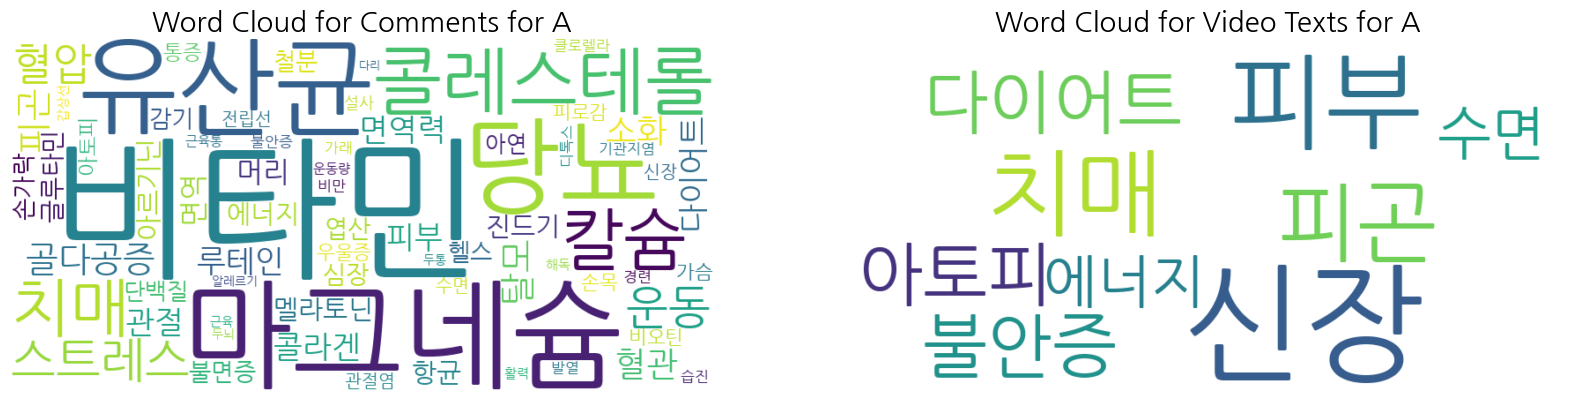

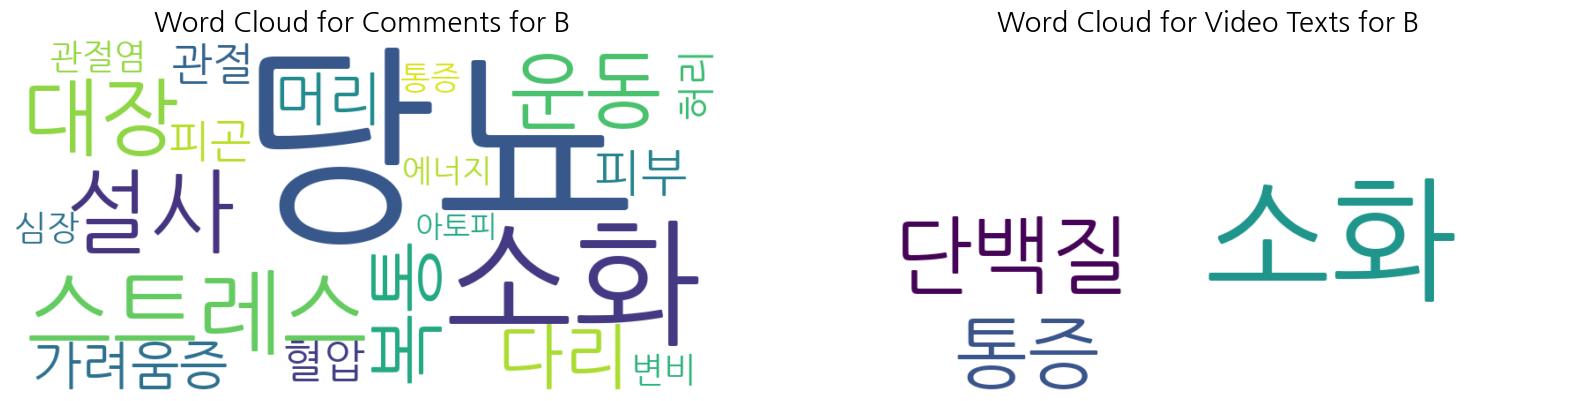

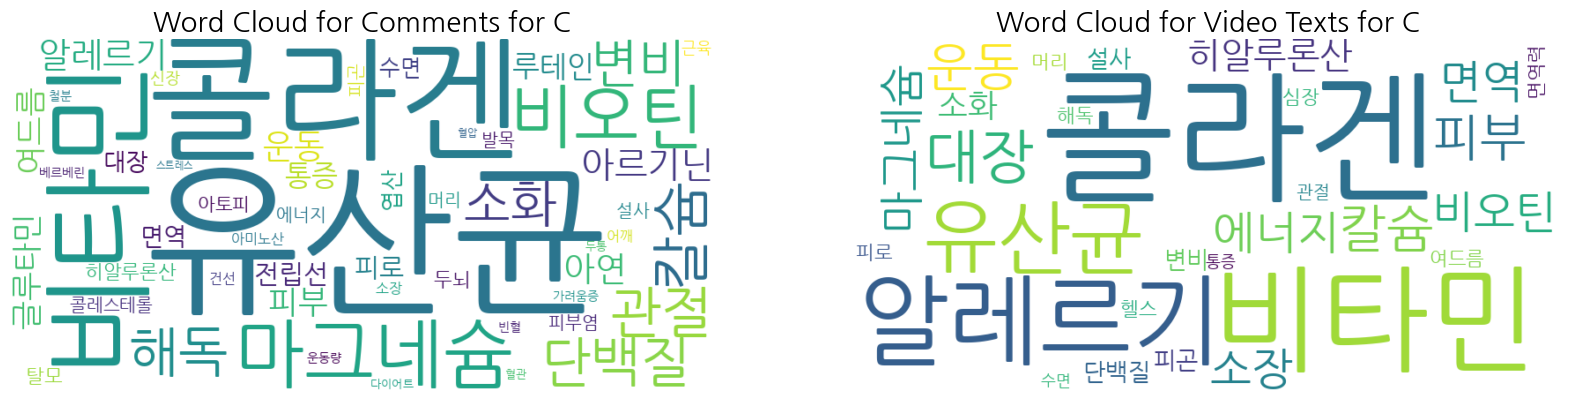

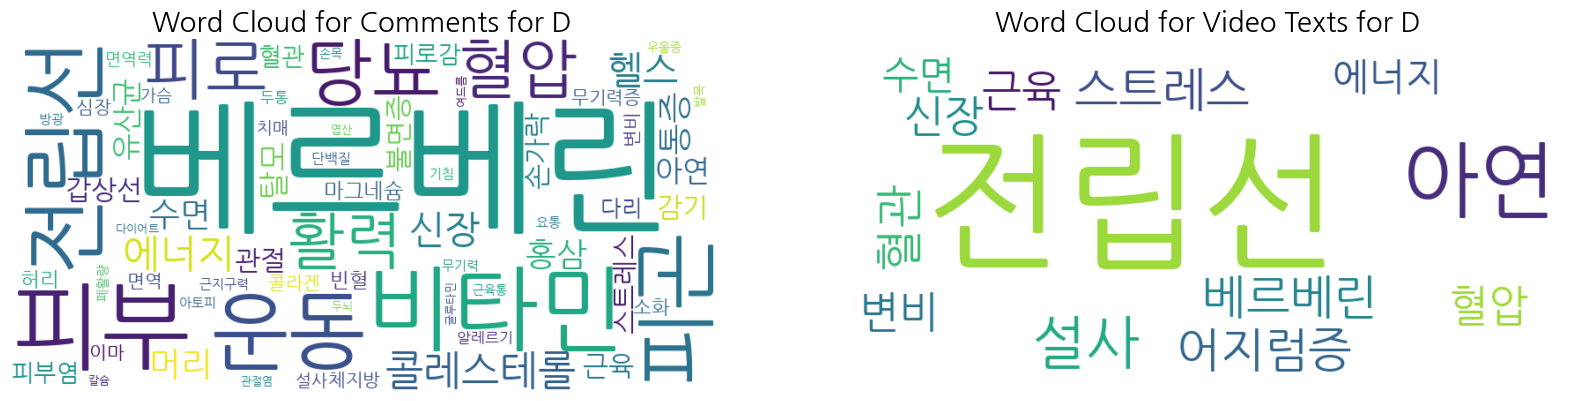

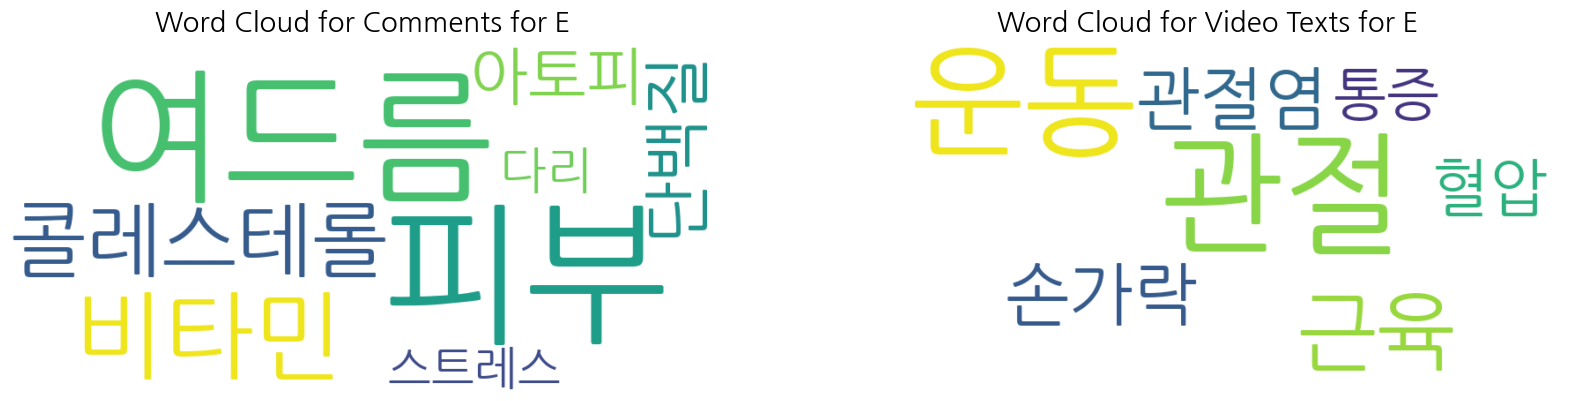

In [25]:
# 워드 클라우드 생성 및 시각화 함수
def generate_word_cloud_from_keywords(keywords, title, ax):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로
        colormap='viridis'
    ).generate_from_frequencies(keywords)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=20)
    ax.axis('off')

# 채널구분별로 Comments와 Video Texts에 대한 워드 클라우드를 좌우로 배치하여 하나로 통합
def create_combined_word_clouds(tfidf_df_comments, tfidf_df_video, title_prefix):
    for channel in tfidf_df_comments.index:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        
        # Comments 워드 클라우드
        keywords_comments = tfidf_df_comments.loc[channel].dropna().to_dict()
        generate_word_cloud_from_keywords(keywords_comments, f"{title_prefix} Comments for {channel}", axes[0])
        
        # Video Texts 워드 클라우드
        keywords_video = tfidf_df_video.loc[channel].dropna().to_dict()
        generate_word_cloud_from_keywords(keywords_video, f"{title_prefix} Video Texts for {channel}", axes[1])
        
        plt.show()

# 채널구분별로 Comments와 Video Texts에 대한 워드 클라우드 생성 및 통합
create_combined_word_clouds(tfidf_df, tfidf_df_video, "Word Cloud for")

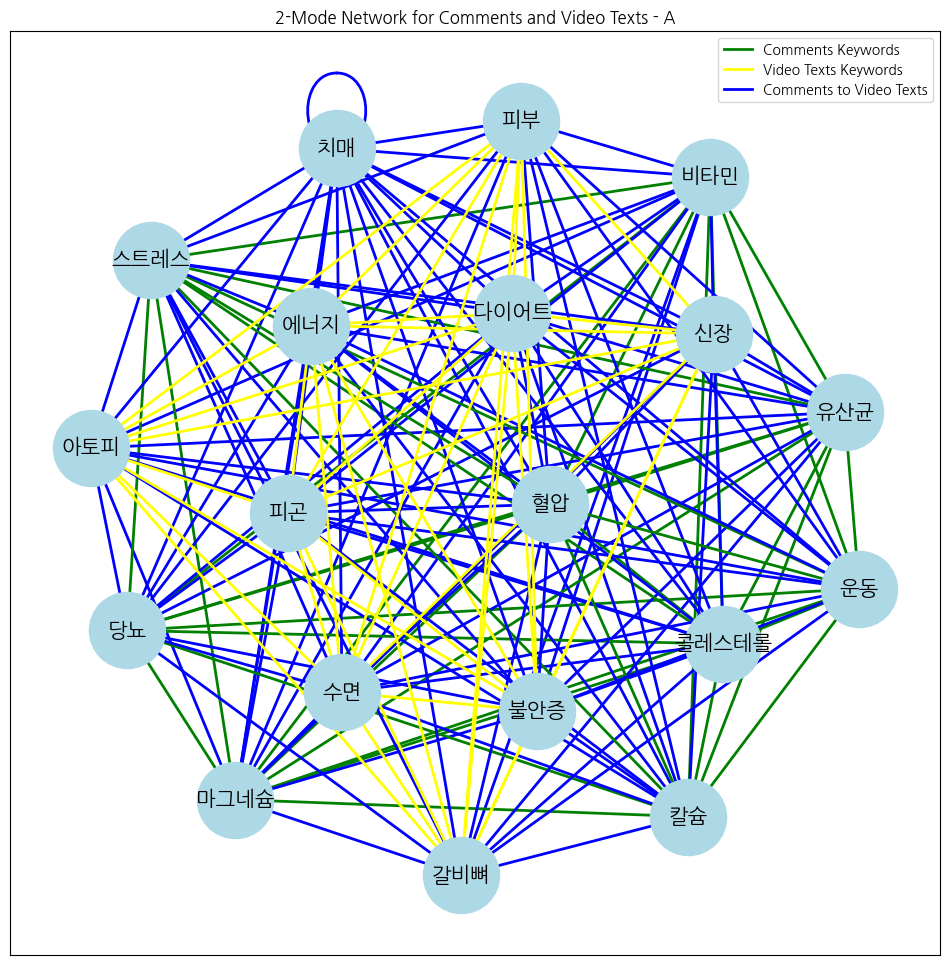

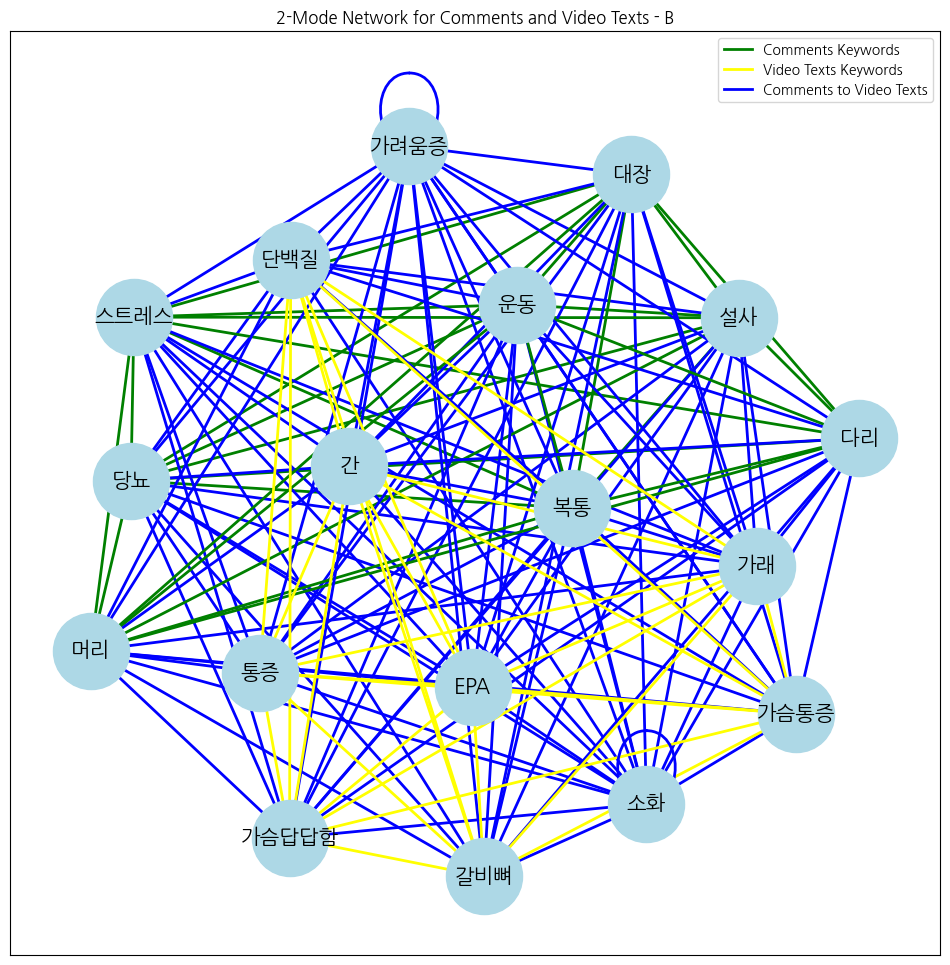

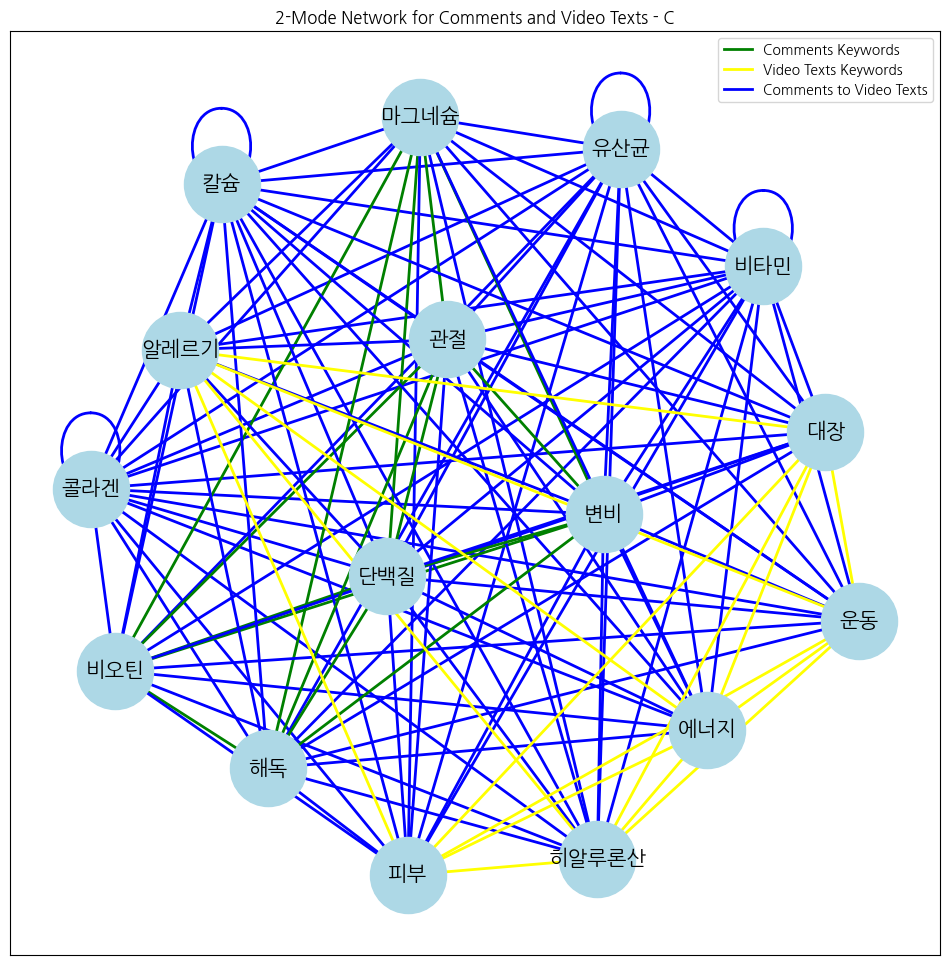

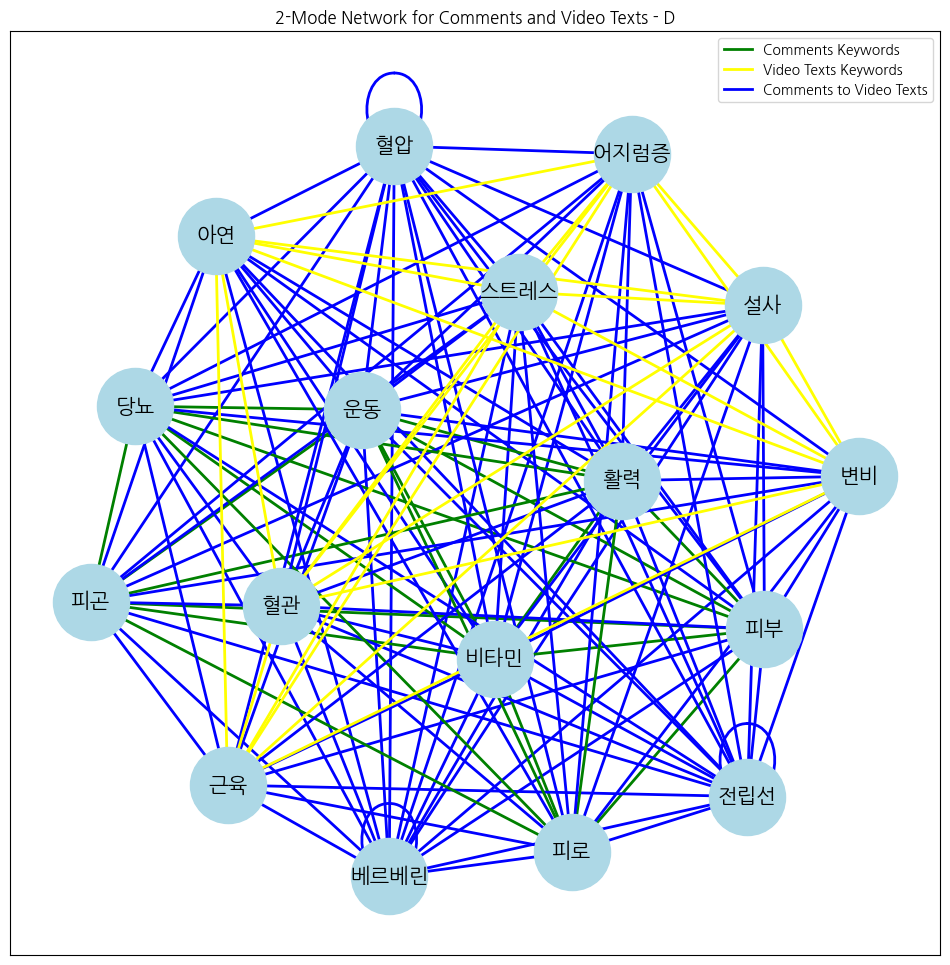

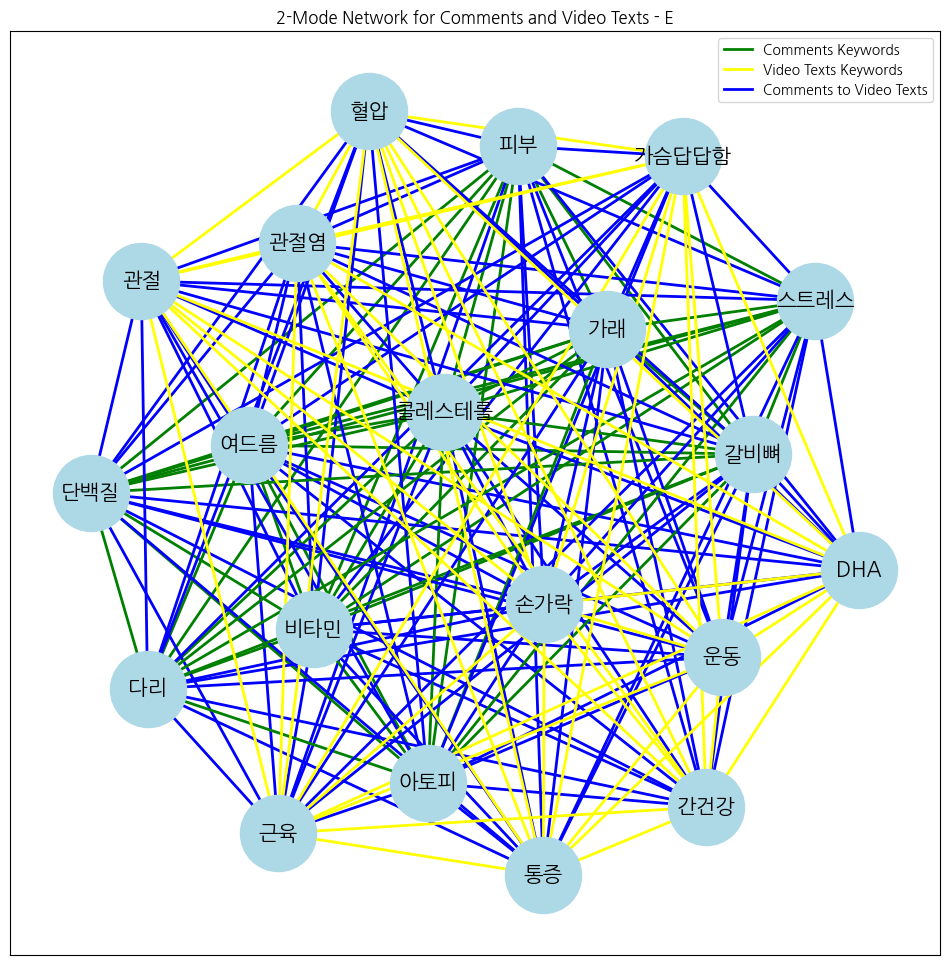

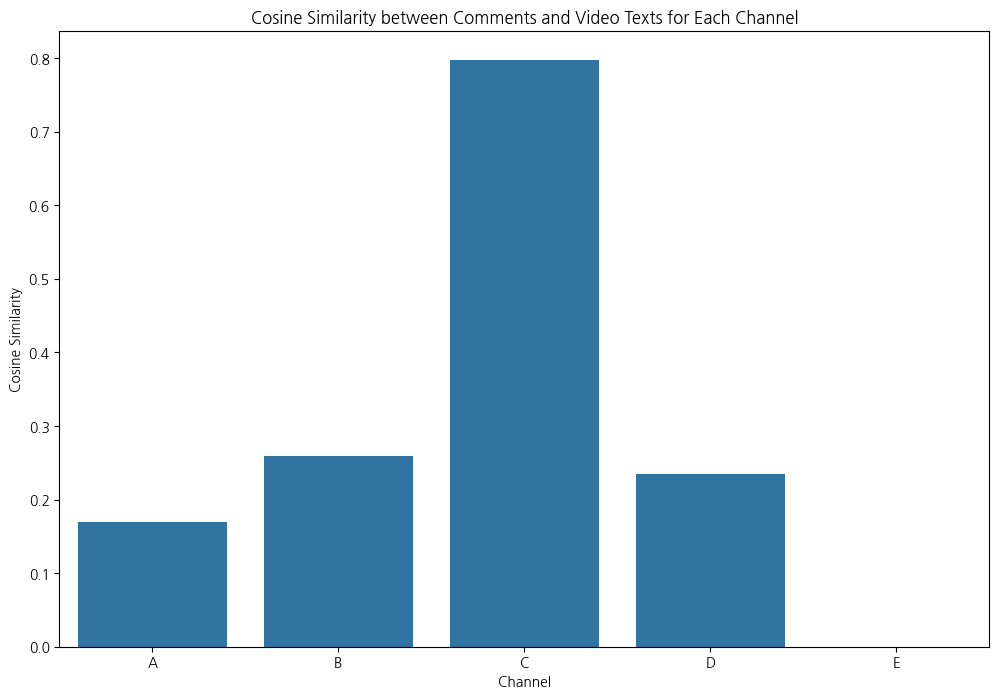

유사도 통계 요약:
count    5.000000
mean     0.291949
std      0.299989
min      0.000000
25%      0.169207
50%      0.234100
75%      0.259258
max      0.797181
dtype: float64


In [38]:
# 추출된 영상 텍스트에 대해 키워드 네트워크를 만들고 시각화
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# 한글 폰트 설정 (예: NanumGothic, AppleGothic, Malgun Gothic 등)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 폰트 경로를 시스템에 맞게 설정
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 2-mode 네트워크 생성 함수
def create_2mode_network(tfidf_df_comments, tfidf_df_video, channel, top_n=10):
    G = nx.Graph()
    
    # 댓글 키워드
    comment_keywords = tfidf_df_comments.loc[channel].sort_values(ascending=False).head(top_n).index
    # 영상 텍스트 키워드
    video_keywords = tfidf_df_video.loc[channel].sort_values(ascending=False).head(top_n).index
    
    # 댓글 키워드 간의 엣지 추가 (녹색)
    for i, keyword1 in enumerate(comment_keywords):
        for keyword2 in comment_keywords[i+1:]:
            G.add_edge(keyword1, keyword2, color='green')
    
    # 영상 텍스트 키워드 간의 엣지 추가 (노랑색)
    for i, keyword1 in enumerate(video_keywords):
        for keyword2 in video_keywords[i+1:]:
            G.add_edge(keyword1, keyword2, color='yellow')
    
    # 댓글 키워드와 영상 텍스트 키워드 간의 엣지 추가 (파란색)
    for comment_keyword in comment_keywords:
        for video_keyword in video_keywords:
            G.add_edge(comment_keyword, video_keyword, color='blue')
    
    return G

# 네트워크 시각화 함수
def visualize_2mode_network(G, title):
    pos = nx.spring_layout(G, k=0.3)
    edges = G.edges(data=True)
    colors = [edge[2]['color'] for edge in edges]
    
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000)
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=15, font_family=font_name)
    plt.title(title)
    
    # 범례 추가
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=2, label='Comments Keywords'),
        plt.Line2D([0], [0], color='yellow', lw=2, label='Video Texts Keywords'),
        plt.Line2D([0], [0], color='blue', lw=2, label='Comments to Video Texts')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.show()

# 채널별 2-mode 네트워크 생성 및 시각화
for channel in tfidf_df_video.index:
    network_2mode = create_2mode_network(tfidf_df, tfidf_df_video, channel, top_n=10)
    visualize_2mode_network(network_2mode, f"2-Mode Network for Comments and Video Texts - {channel}")

# 채널별 댓글과 영상 텍스트 간 유사도 계산 함수
def calculate_cosine_similarity(tfidf_df_comments, tfidf_df_video):
    similarities = {}
    for channel in tfidf_df_comments.index:
        comments_vector = tfidf_df_comments.loc[channel].values.reshape(1, -1)
        video_vector = tfidf_df_video.loc[channel].values.reshape(1, -1)
        similarity = cosine_similarity(comments_vector, video_vector)[0][0]
        similarities[channel] = similarity
    return similarities

# 유사도 시각화 함수
def visualize_similarities(similarities, title):
    channels = list(similarities.keys())
    similarity_values = list(similarities.values())
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=channels, y=similarity_values)
    plt.xlabel('Channel')
    plt.ylabel('Cosine Similarity')
    plt.title(title)
    plt.show()

# Comments와 Video Texts에 대한 코사인 유사도 계산
similarities = calculate_cosine_similarity(tfidf_df, tfidf_df_video)

# 유사도 시각화
visualize_similarities(similarities, "Cosine Similarity between Comments and Video Texts for Each Channel")

# 유사도 통계 분석
similarity_series = pd.Series(similarities)
print("유사도 통계 요약:")
print(similarity_series.describe())



In [39]:
from scipy.stats import ttest_ind
import networkx as nx
import numpy as np

# 퍼뮤테이션 테스트 함수
def permutation_test(data1, data2, num_permutations=10000):
    observed_diff = np.mean(data1) - np.mean(data2)
    combined = np.concatenate([data1, data2])
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        perm_data1 = combined[:len(data1)]
        perm_data2 = combined[len(data1):]
        perm_diff = np.mean(perm_data1) - np.mean(perm_data2)
        if perm_diff >= observed_diff:
            count += 1
    p_value = count / num_permutations
    return p_value

# 네트워크 속성 계산 함수
def calculate_network_properties(G):
    centrality = nx.degree_centrality(G)
    clustering = nx.clustering(G)
    modularity = nx.algorithms.community.modularity(G, nx.algorithms.community.greedy_modularity_communities(G))
    return centrality, clustering, modularity

# 네트워크 속성 비교 함수
def compare_network_properties(G1, G2):
    centrality1, clustering1, modularity1 = calculate_network_properties(G1)
    centrality2, clustering2, modularity2 = calculate_network_properties(G2)
    
    centrality_diff = np.mean(list(centrality1.values())) - np.mean(list(centrality2.values()))
    clustering_diff = np.mean(list(clustering1.values())) - np.mean(list(clustering2.values()))
    modularity_diff = modularity1 - modularity2
    
    return centrality_diff, clustering_diff, modularity_diff

# 통계 분석
def statistical_analysis(tfidf_df_comments, tfidf_df_video):
    similarities = calculate_cosine_similarity(tfidf_df_comments, tfidf_df_video)
    similarity_values = list(similarities.values())
    
    # 퍼뮤테이션 테스트
    p_value = permutation_test(similarity_values, np.random.permutation(similarity_values))
    print(f"Permutation Test p-value: {p_value}")
    
    # 네트워크 속성 비교
    centrality_diffs = []
    clustering_diffs = []
    modularity_diffs = []
    
    for channel in tfidf_df_video.index:
        G_comments = create_keyword_network(tfidf_df_comments, channel, top_n=10)
        G_video = create_keyword_network(tfidf_df_video, channel, top_n=10)
        
        centrality_diff, clustering_diff, modularity_diff = compare_network_properties(G_comments, G_video)
        centrality_diffs.append(centrality_diff)
        clustering_diffs.append(clustering_diff)
        modularity_diffs.append(modularity_diff)
    
    # 속성 비교 결과 출력
    print(f"Centrality Difference: {np.mean(centrality_diffs)}")
    print(f"Clustering Coefficient Difference: {np.mean(clustering_diffs)}")
    print(f"Modularity Difference: {np.mean(modularity_diffs)}")

# 통계 분석 실행
statistical_analysis(tfidf_df, tfidf_df_video)

Permutation Test p-value: 0.5337
Centrality Difference: 0.0
Clustering Coefficient Difference: 0.0
Modularity Difference: 0.0
